# AES 128 SCA on real target

With this exercise, you will get your own traces to perform an attack.
The device target uses an unprotected software AES implementation.

# Challenge

Retrieve the AES key used to encrypt the data


In [1]:
#Imports£
%matplotlib widget
import chipwhisperer as cw
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
# Chipwhisperer basic configuration

scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial2)
prog = cw.programmers.STM32FProgrammer
scope.default_setup()

#Chipwhisperer clock is fed to the target chip
scope.clock.clkgen_freq = 24E6
target.baud = 230400*24/7.37

cw.set_all_log_levels(cw.logging.CRITICAL)

# Already decimate the ADC samples. This way, ext_offset matches the ADC samples
scope.adc.samples = 8000
scope.adc.decimate = 4

In [3]:
#Helper functions

def target_reset():
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high_z'
    time.sleep(0.05)
    target.flush()


In [4]:
#Encrypt a plaintext and retrieve the ciphertext
# This can be used as your reference ciphertext for further attacks

target_reset()
scope.arm()
target.simpleserial_write("p", b'0123456789abcdef')
scope.capture()
val = target.simpleserial_read('r', 16)#For loop check
print(val)


CWbytearray(b'7b 22 06 f5 08 49 8b 4d a9 20 60 0e 02 bf f3 af')


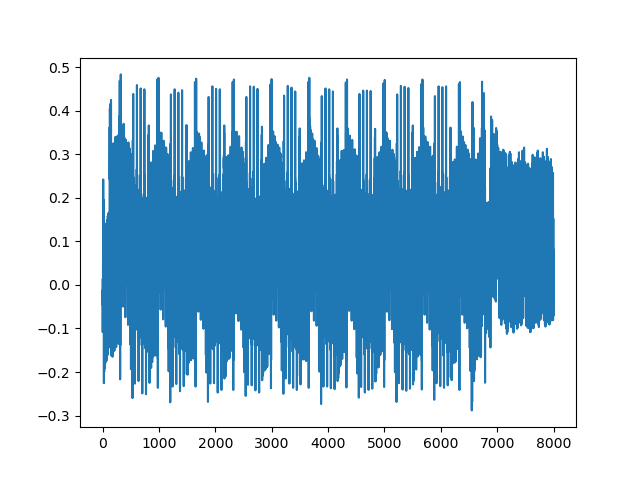

In [5]:
# For the last encryption, show the associated power trace
plt.close()
plt.plot(scope.get_last_trace())

In [6]:
import random
def generate_random_hex(length):
    return ''.join(random.choice('0123456789abcdef') for _ in range(length))


In [7]:
def AES_128(n_times):
    results = []
    for i in range(n_times):
        if (i % 100) == 0 :
            print(i)
        ptext = bytes(generate_random_hex(16),'utf-8')
        target_reset()
        scope.arm()
        target.simpleserial_write("p", ptext)
        scope.capture()
        results.append((ptext, target.simpleserial_read('r', 16), scope.get_last_trace()))
    return results 

results = AES_128(400)

0
100
200
300


In [8]:
ptexts = []
ctexts = []
traces = []


# Parcourir chaque élément de 'results'
for result in results:
    # Ajouter le ctexte et la trace de l'élément actuel dans leurs listes respectives
    ptexts.append(result[0]) # plaintext 
    ctexts.append(result[1])  # ctext est le deuxième élément du tuple
    traces.append(result[2][6200:6900])  # trace est le troisième élément du tuple

# Convertir la liste en une matrice NumPy
ptexts_matrix = np.vstack(ptexts)
ctexts_matrix = np.vstack(ctexts)
traces_matrix = np.vstack(traces)
print(ptexts_matrix[:3])
print(ctexts_matrix[:3])
print(traces_matrix[:3])

[[b'9bfe9ead494d8e1a']
 [b'50d7ec518201d011']
 [b'2b0bf09a56e51311']]
[[155  27  96 191 171   9 169  58 143  44 113  54  18  57 129 186]
 [121  43  46 112  54   0 243  86  69 150 163  72 110   0   9  29]
 [191 173  16 172  27 226  27  35  26  43 123  42  69 132 110 231]]
[[-0.01269531 -0.11425781 -0.05175781 ...  0.1640625   0.078125
   0.10449219]
 [-0.00878906 -0.11230469 -0.04785156 ...  0.16113281  0.07910156
   0.09863281]
 [-0.01074219 -0.12890625 -0.05761719 ...  0.16601562  0.08691406
   0.11230469]]


In [9]:
import sca_training

def calculate_candidates(matrix_ctext, matrix_trace):
    candidates = []
    for b in range(16):
        result_matrix = np.zeros((256, 700))
        for k in range(256):
            xor_c_k10 = np.bitwise_xor(k, matrix_ctext[:,b])
            s10 = sca_training.invSbox[xor_c_k10]
            HW_s10 = [bin(element).count('1') for element in s10]
            pearson_coeffs = [np.corrcoef(HW_s10, matrix_trace[:, i])[0, 1] for i in range(matrix_trace.shape[1])]

            for i, corr_coef in enumerate(pearson_coeffs):
                result_matrix[k,i] = corr_coef
        candidates.append(result_matrix)
        print(b)
    return candidates 

In [10]:
# candidates = calculate_candidates(ctexts_matrix, traces_matrix)
# print("candidates: ", candidates)

In [11]:
# candidate500 = calculate_candidates(ctexts_matrix[:500], traces_matrix[:500])

In [134]:
candidate200 = calculate_candidates(ctexts_matrix[:200], traces_matrix[:200])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


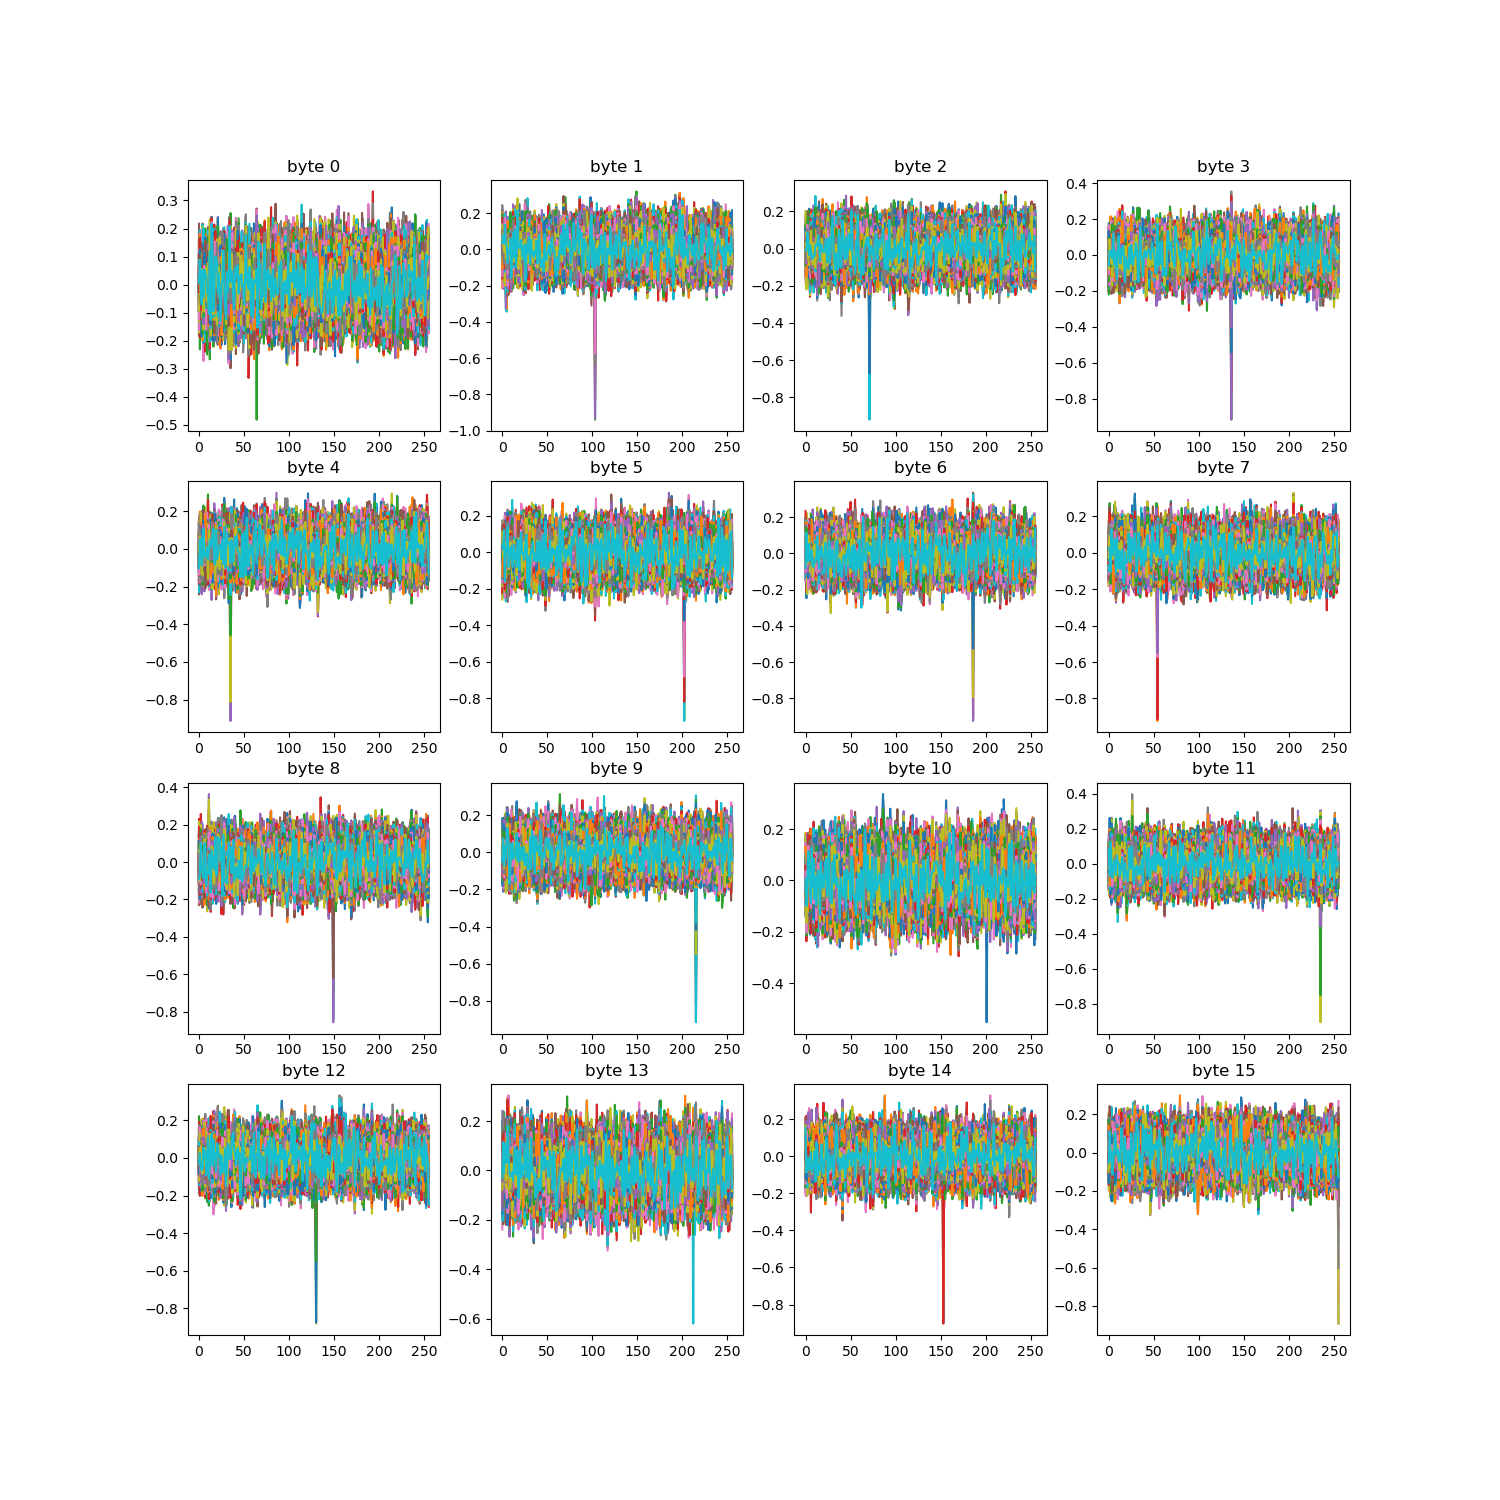

In [13]:
plt.close()
figure, axis = plt.subplots(4,4,figsize=(15, 15))
for i in range(0,4):
    axis[0,i].plot(candidate200[i])
    axis[0,i].set_title("byte " + str(i))
    
    axis[1,i].plot(candidate200[4+i])
    axis[1,i].set_title("byte " + str(i+4))

    axis[2,i].plot(candidate200[8+i])
    axis[2,i].set_title("byte " + str(i+8))

    axis[3,i].plot(candidate200[12+i])
    axis[3,i].set_title("byte " + str(i+12))

plt.show()

In [135]:
for i in range(0, 16):
    print("byte", i)
    original_copy = np.copy(candidate200[i])  # Créer une copie du tableau original
    
    for j in range(0, 3):
        max_index = np.unravel_index(np.argmax(np.abs(original_copy)), original_copy.shape)
        
        if max_index[0] < original_copy.shape[0]:
            xmax = original_copy[max_index]
            print(max_index, xmax)
            original_copy[max_index[0], :] = 0  # Supprimer la ligne entière
            original_copy[max_index] = 0  # Mettre à zéro dans la copie pour éviter de le sélectionner à nouveau
        else:
            print("Error: Index out of bounds")

byte 0
(64, 142) -0.4815748053213781
(55, 143) -0.3324176671914239
(193, 143) 0.33229962501685856
byte 1
(103, 22) -0.9391358302056646
(5, 199) -0.3435452955269484
(4, 199) -0.33468551859050566
byte 2
(71, 69) -0.9193734062351578
(40, 67) -0.36161848748144254
(114, 404) -0.3583719630373861
byte 3
(136, 112) -0.9165211792929316
(109, 412) -0.31121323045225907
(89, 113) -0.3098406998229267
byte 4
(35, 14) -0.9130850342627416
(132, 13) -0.35804881160779184
(112, 610) -0.3135297863119017
byte 5
(202, 59) -0.9235002841664007
(103, 433) -0.3734675949365823
(185, 434) 0.3271041888007638
byte 6
(186, 104) -0.9248242853937181
(28, 258) -0.3292720083413411
(91, 103) -0.3259896768714068
byte 7
(54, 1) -0.9234820671658761
(205, 8) 0.32930321267847207
(29, 450) 0.32478208202857106
byte 8
(149, 54) -0.8563050391015067
(11, 164) 0.3634633290764056
(135, 163) 0.34624543536437447
byte 9
(215, 99) -0.9161591336967374
(64, 222) 0.3144662821891159
(113, 349) 0.3039923776603872
byte 10
(201, 230) -0.552363

In [102]:
res = [64, 103, 71, 136, 35, 202, 186, 54, 149, 215, 201, 235, 130, 212, 153, 255]
len(res)

master_key = sca_training.get_master_key(np.array(res))
master_key_ascii = "".join(chr(c) for c in master_key)

print(master_key_ascii)

SCA{RealAES-128}
